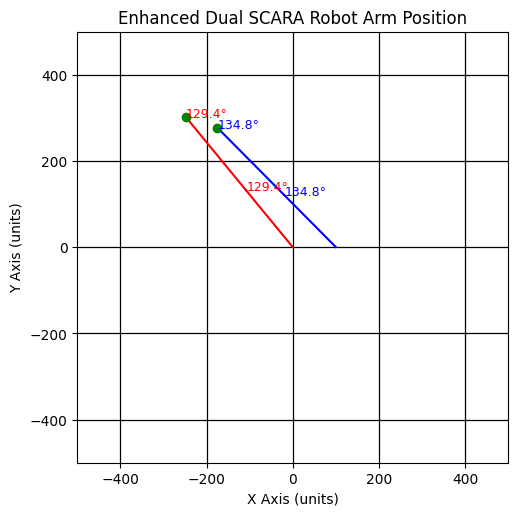

In [1]:
import tkinter as tk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import Scale

# Define constants
OFFSET = 200
L1 = 200
L2 = 300

def inverse_kinematics_dual(x, y):
    def calculate_angles(x, y, flip_theta2=False):
        r = np.sqrt(x**2 + y**2)
        cos_theta_2 = (r**2 - L1**2 - L2**2) / (2 * L1 * L2)
        theta_2 = np.arccos(np.clip(cos_theta_2, -1.0, 1.0))
        if flip_theta2:
            theta_2 = -theta_2
        k1 = L1 + L2 * np.cos(theta_2)
        k2 = L2 * np.sin(theta_2)
        theta_1 = np.arctan2(y, x) - np.arctan2(k2, k1)
        return np.degrees(theta_1), np.degrees(theta_2)

    theta1_1, theta2_1 = calculate_angles(x, y, y > 0)
    theta1_2, theta2_2 = calculate_angles(x - OFFSET, y, y < 0)

    return (theta1_1, theta2_1), (theta1_2, theta2_2)

def plot_dual_scara_arm(ax, theta1_1, theta2_1, theta1_2, theta2_2):
    ax.clear()

    def plot_arm(ax, theta1, theta2, offset_x, color):
        theta1 = np.radians(theta1)
        theta2 = np.radians(theta2)
        joint1 = (offset_x + L1 * np.cos(theta1), L1 * np.sin(theta1))
        joint2 = (joint1[0] + L2 * np.cos(theta1 + theta2), joint1[1] + L2 * np.sin(theta1 + theta2))
        
        # Plot arms
        ax.plot([offset_x, joint1[0]], [0, joint1[1]], f'{color}-')
        ax.plot([joint1[0], joint2[0]], [joint1[1], joint2[1]], f'{color}-')
        ax.plot(joint2[0], joint2[1], 'go')

        # Display angles
        ax.text(joint1[0], joint1[1], f'{np.degrees(theta1):.1f}°', color=color, fontsize=9)
        ax.text(joint2[0], joint2[1], f'{np.degrees(theta1 + theta2):.1f}°', color=color, fontsize=9)

    # Plot both arms
    plot_arm(ax, theta1_1, theta2_1, 0, 'r')
    plot_arm(ax, theta1_2, theta2_2, OFFSET, 'b')

    # Axis and grid settings
    ax.set_xlim(-500, 500)
    ax.set_ylim(-500, 500)
    ax.set_xlabel('X Axis (units)')
    ax.set_ylabel('Y Axis (units)')
    ax.set_title('Enhanced Dual SCARA Robot Arm Position')
    ax.grid(which='major', linestyle='-', linewidth=0.9, color='black')
    ax.grid(which='minor', linestyle='--', linewidth=0.5, color='gray')
    ax.set_aspect('equal', adjustable='box')


def on_mouse_move(event):
    global canvas, x_target, y_target, ax
    plot_range = 1000  # As the plot limit is [-500, 500]
    
    # Calculate the scale factors based on plot range and widget size
    scale_x = plot_range / canvas_widget.winfo_width()
    scale_y = plot_range / canvas_widget.winfo_height()

    # Additional vertical offset (adjust this value as needed)
    vertical_offset = 40  # Example value, adjust as needed
    
    # Transform canvas coordinates to plot coordinates
    x_target = (event.x - canvas_widget.winfo_width() / 2) * scale_x
    y_target = -(event.y - canvas_widget.winfo_height() / 2 - vertical_offset) * scale_y
    update_plot()


def update_plot():
    global canvas, x_target, y_target, ax
    (theta1_1, theta2_1), (theta1_2, theta2_2) = inverse_kinematics_dual(x_target, y_target)
    plot_dual_scara_arm(ax, theta1_1, theta2_1, theta1_2, theta2_2)
    canvas.draw()

# Function to be called when the button is clicked
def reset_arm_position():
    global x_target, y_target
    x_target, y_target = 0, 0
    update_plot()

# Function to adjust arm length upperr arm

def adjust_arm_length(scale_value):
    global L1  # or L2 if you're adjusting the second arm segment
    L1 = int(scale_value)
    update_plot()

# function to adjust arm length lower arm
def adjust_arm_length_low(scale_value):
    global L2  # or L2 if you're adjusting the second arm segment
    L2 = int(scale_value)
    update_plot()

# function to adjust offset
def adjust_offset(scale_value):
    global OFFSET  # or L2 if you're adjusting the second arm segment
    OFFSET = int(scale_value)
    update_plot()

# fucntion to calculate best offset (l1-l2)
def best_offset():
    global OFFSET
    OFFSET = (L2 - L1)*2
    update_plot()


root = tk.Tk()
root.title("Interactive Dual SCARA Robot Arm")

# Adding a reset button
reset_button = tk.Button(root, text="Reset Position", command=reset_arm_position)
reset_button.pack(side=tk.BOTTOM)

# Adding a slider for adjusting arm length
length_slider = Scale(root, from_=100, to=300, orient='horizontal', label="Adjust Arm Length (L1)", tickinterval=10, resolution=10, command=adjust_arm_length)
length_slider.pack(side=tk.BOTTOM)

# Adding a slider for adjusting arm length lower arm
length_slider_low = Scale(root, from_=100, to=300, orient='horizontal', label="Adjust Arm Length (L2)",tickinterval=10, resolution=10, command=adjust_arm_length_low)
length_slider_low.pack(side=tk.BOTTOM)

# adjust offset
offset_slider = Scale(root, from_=100, to=300, orient='horizontal', label="Adjust Offset", tickinterval=10, resolution=10, command=adjust_offset)
offset_slider.pack(side=tk.BOTTOM)

#button to calculate best offset
best_offset_button = tk.Button(root, text="Best Offset", command=best_offset)
best_offset_button.pack(side=tk.BOTTOM)


fig, ax = plt.subplots(figsize=(10, 10))
canvas = FigureCanvasTkAgg(fig, master=root)
canvas_widget = canvas.get_tk_widget()

canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

root.bind('<Motion>', on_mouse_move)

root.mainloop()
